<a href="https://colab.research.google.com/github/jpmedras/inf450_2023-1/blob/main/Demo_Direct_Mapping_Cache_Gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho inf450 Cache Write-back

* Cache Mapeamento Direto
* Write-back
* Máquina de estados para Teste da Cache
  * Ler um sequencia da memoria

  
posicao | operacao | endereco | dado
---     | ---      | ---|---
0 | 0 (read) | 30 |
1 | 1 (write) | 21 | 3
... |
10 | 1 (write) | 44 | 1

* O sistema deve monitorar o total de ciclos para a execução da sequencia
* Mostrar o número de MISS


[playlist com explicações](https://www.youtube.com/playlist?list=PLcvOyD_LMr6kDv1GhR8eLMkzxwKzXGDvo)



# Referencias

* Fazer as adaptações no trabalho de cache  [Colab Mapeamento Direto em Verilog](https://colab.research.google.com/drive/1bh5ODMjvlMs8Zem0-SQ6tOvOpMCL16Ob?usp=sharing)



* Referências para Memória [com colab](https://colab.research.google.com/drive/1EKR4iBx_EGQgHr4tDHwQXRv_OY65b5CP?usp=sharing)



# Maquina de Estados com Write-back

## [Descrição do projeto](https://excalidraw.com/#json=NUkS9gpN7MOLbnIfPlsuJ,lbAEMzmIIlkMNQfdWim_Yg)

## Diagrama da Maquina

* Alterar a FSM da read-only

In [25]:
from graphviz import Digraph
e = Digraph('fsmCache', filename='fsmCache.gv')

e.attr('node', shape='box')

with e.subgraph() as s:
    s.attr(rank='bottom')
    s.node('ReadData', label = 'ReadData Done == 1')
    s.node('ReadTag', label = 'ReadTag Cnt == 1 & Mux == 0',shape="box3d")
    s.node('WriteData', label = 'WriteData Done == 1')

e.edge('ReadTag','ReadData','c & v & ~op')
e.edge('ReadTag','ReadBlock','(~v) | (~c & ~w)')
e.edge('ReadTag','WriteBlock','~c & v & w')


with e.subgraph() as s:
    s.attr(rank='top')
    s.node('ReadBlock', label = 'ReadBlock Dwr == 1 & Mux == 1')
    s.node('UpdateTag', label = 'UpdateTag Twr == 1')
    s.node('WriteBlock', label = 'WriteBlock \n RAMwr == 1 & Mux == 1')

e.edge('ReadData','ReadTag')
e.edge('ReadBlock','UpdateTag','RB_End');
e.edge('ReadBlock','ReadBlock','¬RB_End')
e.edge('WriteBlock','ReadBlock','WB_End')
e.edge('WriteBlock','WriteBlock','¬WB_End')
e.edge("UpdateTag","ReadData", '~op')

with e.subgraph() as s:
    s.node('WriteData', label = 'WriteData Done == 1 Dwr == 1')
    s.node('UpdateDirty', label = 'UpdateDirty DTwr == 1')

e.edge('ReadTag','WriteData','c & v & op');
e.edge('UpdateTag','UpdateDirty','op');
e.edge('UpdateDirty','WriteData');
e.edge('WriteData', 'ReadTag')

e.view()


# assign wRAM = (~c & v & w);
# assign rRAM = (~v) | (~c & ~w);
# assign rCache = (c & v);

'fsmCache.gv.pdf'

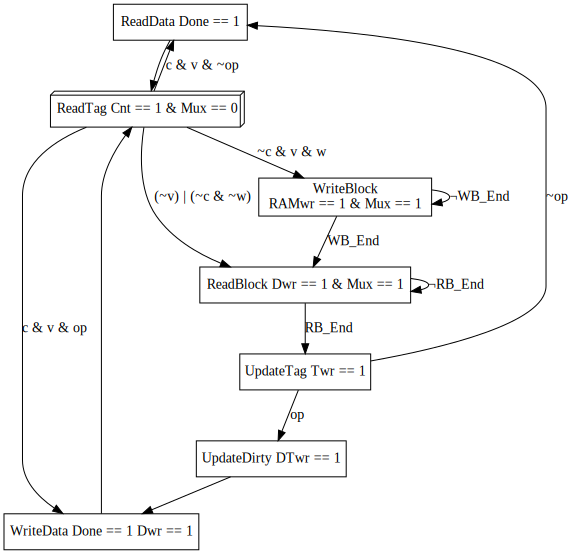

In [26]:
#@title Final State Machine Visualization
from graphviz import Source
Source.from_file('fsmCache.gv') # visualizando

## Código Verilog

[esboço das mudancas](https://excalidraw.com/#json=tA8BlVuaEDYLh1P6uK1IV,wtL9VBNzucDj81_xj67iAA)

* criar uma memoria de 1 bit (clonar a memoria de valido) para anotar se os dados mudaram na cache (write back).


# Projeto da Cache Mapeamento Direto com Write-back

Adaptar a cache só de leitura.

# Funções para Visualizar o Resultado

* Mostrar a Cache
* Mostrar as células de memória que foram atualizadas

# Maquina de Estados para Consulta e Teste da Cache

# Direct Mapping Cache Assignment (Leitura e Escrita)

* Implement the **Gradio Interface** for a Verilog code to simulate a direct mapping cache
* The Cache will be read only.
* This Colab NB has already a direct mapping parametrized cache as your starting point.

# Installing

In [27]:
!pip install git+https://github.com/lesc-ufv/cad4u >& /dev/null
!git clone https://github.com/lesc-ufv/cad4u >& /dev/null
%load_ext plugin

The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


## Cache Schematic

[Link desenho Excalidraw](https://excalidraw.com/#json=ej9ztRutvSeb-U4kcyzoU,9vOhV989mUYXB_yNNr03jA)

<img src="https://github.com/arduinoufv/inf450/blob/master/cache/figuras/cacheMD_gradio_esboco.png?raw=true" alt="blind" width="600"/>

## Verilog Code
* All modules are implelemented on different files.


### Block address multiplexer

* For the DM cache, it is used to select between request block address and the internal block counter to fill the cache block.

In [28]:
%%writefile mux.v
module  mux(
din_0      , // Mux first input
din_1      , // Mux Second input
sel        , // Select input
mux_out      // Mux output
);
parameter bitsBlock = 3;
//-----------Input Ports---------------
input [bitsBlock-1:0] din_0;
inout [bitsBlock-1:0] din_1;
input sel ;
//-----------Output Ports---------------
output [bitsBlock-1:0] mux_out;
//-------------Code Start-----------------
assign mux_out = (sel) ? din_1 : din_0;

endmodule //End Of Module mux


Overwriting mux.v


### Tag Comparator

* Compare current address tag to Cache tag address

In [29]:
%%writefile comparator.v
module comparator(out, tag, tag_in);
parameter bitsTag = 6;
  output  out;
  input   [bitsTag-1:0] tag;
  input   [bitsTag-1:0] tag_in;

assign out =  ( tag == tag_in )? 1 : 0;

endmodule

Overwriting comparator.v


### Mtag Cache
* Memory to store the cache Tags.

In [30]:

%%writefile Mtag.v
module Mtag ( clk, line,  din, wr, dout , reset);
parameter bitsLinesCache = 2;
parameter bitsTag = 6;
parameter linesCache = 4;

input clk;
input [bitsLinesCache-1:0] line;
input [bitsTag-1:0] din;
input wr;
output [bitsTag-1:0] dout;
input reset;


reg [bitsTag-1:0] memory[0:linesCache-1];
reg [bitsTag-1:0] dout;

always @(posedge clk )
  begin
    if (wr)
      memory[line] <= din;
  end

always @ (*)
  begin
  dout <= memory[line];
  end

always @( posedge reset)
			if(reset)
				begin
				  memory[0] <= 6'h3;
				  memory[1] <= 6'h4;
				  memory[2] <= 6'h5;
				  memory[3] <= 6'h6;
				end


endmodule

Overwriting Mtag.v


### Cache Valid Bit
* Memory with reset signal to store the valid bit. One per line.

In [31]:

%%writefile valid.v
module valid ( clk, line,  reset, wr, dout );
parameter bitsLinesCache = 2;
parameter linesCache = 4;
input clk;
input [bitsLinesCache-1:0] line;
input reset;
input wr;
output dout;

reg memory[0:linesCache-1];
reg dout;

always @(posedge clk )
  begin
    if (wr)
      memory[line] <= 1;
  end

always @ (*)
  begin
  dout = memory[line];
  end

reg integer i;
always @ (reset)
  begin
  for(i =0;i<linesCache;i=1+i)begin
    memory[i]=0;
  end
  end
endmodule

Overwriting valid.v


### Cache Dirty Bit
* Memory with reset signal to store the dirty bit. One per line.

In [32]:
%%writefile dirty.v
module dirty ( clk, line,  reset, wr, dout );
parameter bitsLinesCache = 2;
parameter linesCache = 4;
input clk;
input [bitsLinesCache-1:0] line;
input reset;
input wr;
output dout;

reg memory[0:linesCache-1];
reg dout;

always @(posedge clk )
  begin
    if (wr)
      memory[line] <= 1;
  end

always @ (*)
  begin
  dout = memory[line];
  end

reg integer i;
always @ (reset)
  begin
  for(i =0;i<linesCache;i=1+i)begin
    memory[i]=0;
  end
  end
endmodule

Overwriting dirty.v


###Data cache
* Memory module to store the data
* May be used to write din in cache. The position is given by {line, blk}


In [33]:
%%writefile datacache.v
module datacache ( clk, line, blk, din, wr, dout );
parameter bitsBlock = 3;
parameter bitLinesCache = 2;
parameter cacheSize = 32;
input clk;
input [bitLinesCache-1:0] line;
input [bitsBlock-1:0] blk;
input [7:0] din;
input wr;
output [7:0] dout;

reg [7:0] memory[0:cacheSize-1];
reg [7:0] dout;

always @(posedge clk )
  begin
    if (wr)
      memory[{line,blk}] <= din;
  end

always @ (*)
  begin
  dout <= memory[{line,blk}];
  end

endmodule

Overwriting datacache.v


### Ram
* Ram Memory Module
* Returns memory address in dout
* Write din if wr == 1

In [34]:
%%writefile ram.v
module ram ( clk, addr, din, wr, dout, reset );
parameter bitsRam = 11;
parameter ramSize = 2048;
input clk;
input [bitsRam-1:0] addr;
input [7:0] din;
input wr;
output [7:0] dout;
input reset;

reg [7:0] memory[0:ramSize-1];
reg [7:0] dout;


always @(posedge clk )
  begin
    if (wr)
      memory[addr] <= din;
  end

always @ (*)
  begin
  dout <= memory[addr];
  end

reg integer i;
 always @(posedge reset)
			if(reset) // starts for testing
				begin
            for(i = 0;i<ramSize;i=i+1)begin
              memory[i] <= i;

            end
				end
endmodule

Overwriting ram.v


### Counter Module
* parameterized Counter: 0 to blockSize - 1
* This counter generates the address to fill the data cache line with a data block.

In [35]:
%%writefile counter.v
module counter(out, clk, reset, End);
  parameter bitsBlock = 3;
  parameter blockSize = 8;
  output [bitsBlock-1 : 0] out;
  input 	       clk, reset;
  output End;

  reg [bitsBlock-1 : 0]   out;
  reg End;
  wire 	       clk, reset;
  wire [bitsBlock-1: 0] limitCounter = blockSize-1;
  always @(posedge clk)
    out <= out + 1;

  always @(posedge clk)
    if ( out == limitCounter )
       End <= 1;
    else
       End <= 0;


  always @(reset)
    if (reset)
      out <= 0;

endmodule // counter

Overwriting counter.v


### Cache Finite State Machine

* Provide FSM diagram using Graphviz

In [46]:
%%writefile fsm.v
module fsm(
  input wire clk, reset, c, v, w, op, RB_End, WB_End,
  output reg Twr, DTwr, Dwr, Rwr, Cnt, Mux, Done);

reg [2:0] state;

parameter ReadTag = 3'b00, ReadData = 3'b01,
ReadBlk = 3'b10, UpdateTag = 3'b11, WriteBlock = 3'b100,
WriteData = 3'b101, UpdateDirty = 3'b110, RESET = 3'b111;

/* State register (synchronous reset) */
always @(posedge clk or posedge reset)
begin
  if (reset)
    state <= RESET;
  else
    case (state)
      RESET: state <= ReadTag;

      ReadTag:
        if (c & v & ~op) state <= ReadData;
        else if (c & v & op) state <= WriteData;
        else if ((~v) || (~c & ~w))  state <= ReadBlk;
        else state <= WriteBlock;
      ReadData:
        state <= ReadTag;

      WriteData:
        state <= ReadTag;

      ReadBlk:
        if (RB_End) state <= UpdateTag;
        else     state <= ReadBlk;

      WriteBlock:
        if (WB_End) state <= ReadBlk;
        else        state <= WriteBlock;

      UpdateTag:
        if (op) state <= UpdateDirty;
        else    state <= ReadData;

      UpdateDirty:
        state <= WriteData;

  endcase
end

/* Output logic */
always @(*) begin
  Cnt = (state == ReadTag);
  Twr = (state == UpdateTag);
  DTwr = (state == UpdateDirty);
  Dwr = (state == ReadBlk || state == WriteData);
  Rwr = (state == WriteBlock);  // RAM Write
  Mux = (state == ReadBlk || state == WriteBlock);
  Done = (state == ReadData || state == WriteData);
end

endmodule

Overwriting fsm.v


#### Graphviz

In [43]:
# installing the Graphviz
!apt install -y graphviz >& /dev/null
!pip install graphviz  >& /dev/null

In [44]:

from graphviz import Digraph
e = Digraph('fsmCache', filename='fsmCache.gv')

e.attr('node', shape='box')

with e.subgraph() as s:
    s.attr(rank='bottom')
    s.node('ReadData', label = 'ReadData Done == 1')
    s.node('ReadTag', label = 'ReadTag Cnt == 1',shape="box3d")

e.edge('ReadTag','ReadData','c&v');
e.edge('ReadTag','ReadBlock','¬(c&v)');

e.edge('ReadData','ReadTag');


with e.subgraph() as s:
    s.attr(rank='top')
    s.node('ReadBlock', label = 'ReadBlock Dwr == & 1 Mux == 1')
    s.node('UpdateTag', label = 'UpdateTag Twr == 1')

e.edge('ReadBlock','UpdateTag','END');
e.edge('ReadBlock','ReadBlock','¬END');

e.edge("UpdateTag","ReadTag")
e.view()

'fsmCache.gv.pdf'

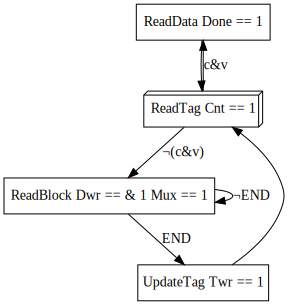

In [45]:
from graphviz import Source
Source.from_file('fsmCache.gv') # visualizando

## Main Project

### Modulo Main.v

Must include submodules created to parameterized cache implementation


Installing. Please wait... done!
The process occurred error, see below the error:

./fsm.v:36: error: Unable to bind wire/reg/memory `ReadBlock' in `cache_read_only.FSM'
1 error(s) during elaboration.



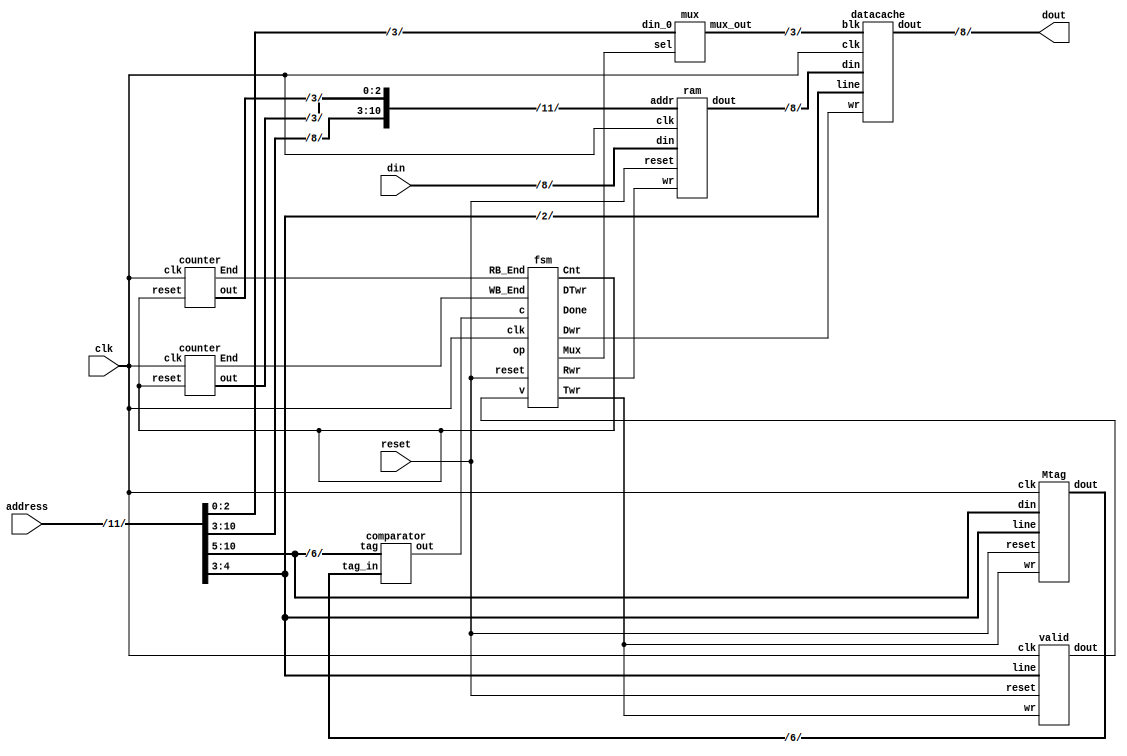

In [17]:
%%print_verilog -top cache_read_only

`include "fsm.v"
`include "mux.v"
`include "ram.v"
`include "valid.v"
`include "dirty.v"
`include "comparator.v"
`include "counter.v"
`include "Mtag.v"
`include "datacache.v"

// *** ADD MODULES HERE ***

module cache_read_only(
clk, reset, address, dout, din
);
parameter cacheSize = 32;
parameter ramSize = 2048;
parameter blockSize = 8;

parameter cacheLines = 4;
parameter cacheLineBits = 2;
parameter ramBits = 11;
parameter blockBits = 3;
parameter tagBits = 6;

input clk;
input reset;

input [ramBits-1:0] address;

output [7:0] dout;
input [7:0] din;

reg [7:0] dout;

wire [cacheLineBits-1:0] line;

wire [blockBits-1:0] blk;

//wire [5:0] tag;
wire [tagBits-1:0] tag;

wire Done;

assign tag = address[ramBits-1:blockBits+cacheLineBits];

assign line = address[blockBits+cacheLineBits-1:blockBits];

assign blk = address[blockBits-1:0];

wire Twr,DTwr,Dwr,Rwr;
wire RB_End, WB_End, cnt, c, v, w, Dmux;
wire [7:0] Ram2Cache;

wire [blockBits-1:0] Mux1;

wire [blockBits-1:0] Muxout;

wire MuxSel;

wire [tagBits-1:0] Tout;

wire [7:0] Cache2out;

always @(*) begin
 dout = Cache2out;
end

fsm  FSM(
  .clk (clk),
  .reset (reset),
  .op (op),
  .c (c) ,
  .v (v),
  .RB_End (RB_End),
  .WB_End (WB_End),
  .Twr (Twr),
  .DTwr (DTwr),
  .Dwr (Dwr),
  .Rwr (Rwr),
  .Cnt (Cnt),
  .Mux (MuxSel) , .Done(Done));

valid V( .clk (clk), .line (line), .reset (reset),
         .wr (Twr), .dout(v) );

dirty D( .clk (clk), .line (line), .reset (reset),
         .wr (DTwr), .dout(w) );

Mtag  T( .clk (clk), .line (line),  .din(tag),
       .wr(Twr), .dout(Tout), .reset(reset) );

comparator comp(.out(c), .tag(tag), .tag_in(Tout));

datacache  dcache( .clk (clk), .line (line), .blk(Muxout),
                  .din(Ram2Cache), .wr(Dwr), .dout(Cache2out) );

ram  R ( .clk(clk), .addr({tag,line,Mux1}), .din(din), .wr(Rwr), .dout(Ram2Cache), .reset(reset) );

wire [ramBits:0] concat_addr;

assign concat_addr = {tag,line,Muxout};

mux  DataMux( .din_0 (blk), .din_1(Mux1), .sel(MuxSel) , .mux_out (Muxout));


counter countR(.out(Mux1), .clk(clk), .reset(Cnt), .End(RB_End));

counter countW(.out(Mux1), .clk(clk), .reset(Cnt), .End(WB_End));


endmodule


In [18]:
!pip install svgutils

In [19]:
from IPython.display import SVG
SVG("out.svg")

import svgutils
svg = svgutils.transform.fromfile('out.svg')
originalSVG = svgutils.compose.SVG('out.svg')
originalSVG.scale(0.5)
figure = svgutils.compose.Figure(float(svg.height) * 2, float(svg.width) * 2, originalSVG)
figure.save('New.svg')



In [56]:
%%writefile main.v
`include "fsm.v"
`include "mux.v"
`include "ram.v"
`include "valid.v"
`include "comparator.v"
`include "counter.v"
`include "Mtag.v"
`include "datacache.v"

// *** ADD MODULES HERE ***

module cache_read_only(
clk, reset, op, address, dout, din
);
parameter cacheSize = 32;
parameter ramSize = 2048;
parameter blockSize = 8;

parameter cacheLines = 4;
parameter cacheLineBits = 2;
parameter ramBits = 11;
parameter blockBits = 3;
parameter tagBits = 6;

input clk;
input reset;

//input [10:0] address;
input [ramBits-1:0] address;
input op;

output [7:0] dout;
input [7:0] din;

output [5:0] debug;
//output [tagBits-1:0] debug;

reg [5:0] debug;
//reg [tagBits-1:0] debug;

reg [7:0] dout;

//wire [1:0] line;
wire [cacheLineBits-1:0] line;

//wire [2:0] blk;
wire [blockBits-1:0] blk;

//wire [5:0] tag;
wire [tagBits-1:0] tag;

wire Done;

assign tag = address[ramBits-1:blockBits+cacheLineBits];

assign line = address[blockBits+cacheLineBits-1:blockBits];

assign blk = address[blockBits-1:0];

wire Twr,Dwr,Rwr;
wire RB_End, WB_End, op, cnt, c, v, Dmux;
wire [7:0] Ram2Cache;

wire [blockBits-1:0] Mux1;

wire [blockBits-1:0] Muxout;

wire MuxSel;

wire [tagBits-1:0] Tout;

wire [7:0] Cache2out;

always @(*) begin
 dout = Cache2out;
end

fsm  FSM(
  .clk (clk),
  .reset (reset),
  .op (op),
  .c (c) ,
  .v (v),
  .RB_End (RB_End),
  .WB_End (WB_End),
  .Twr (Twr),
  .DTwr (DTwr),
  .Dwr (Dwr),
  .Rwr (Rwr),
  .Cnt (Cnt),
  .Mux (MuxSel) , .Done(Done));

valid #(cacheLineBits,cacheLines,"validData.txt")V( .clk (clk), .line (line), .reset (reset),
         .wr (Twr), .dout(v) );

Mtag #(cacheLineBits,tagBits,cacheLines,"mtagData.txt") T( .clk (clk), .line (line),  .din(tag),
       .wr(Twr), .dout(Tout), .reset(reset) );

comparator #(tagBits) comp(.out(c), .tag(tag), .tag_in(Tout));

datacache #(blockBits,cacheLineBits,cacheSize) dcache( .clk (clk), .line (line), .blk(Muxout),
                  .din(Ram2Cache), .wr(Dwr), .dout(Cache2out) );

ram #(ramBits,ramSize) R ( .clk(clk), .addr({tag,line,Mux1}), .din(din), .wr(Rwr), .dout(Ram2Cache), .reset(reset) );

wire [ramBits:0] concat_addr;

assign concat_addr = {tag,line,Muxout};

mux #(blockBits) DataMux( .din_0 (blk), .din_1(Mux1), .sel(MuxSel) , .mux_out (Muxout));

counter #(blockBits,blockSize) count_RB(.out(Mux1), .clk(clk), .reset(Cnt), .End(RB_End));
counter #(blockBits,blockSize) count_WB(.out(Mux1), .clk(clk), .reset(Cnt), .End(WB_End));

endmodule


Overwriting main.v


### Testbench Module

Evaluate a cache:
* Cache Size of 64 bytes;
* Ram Size of 4096 bytes;
* Cache Data block of 4 bytes;

#### Parameters file

[Desenho Excalidraw](https://excalidraw.com/#json=Zoi-SJiNSixjRiGovKZp8,zojAkxOQCNkw2CRle1S0vw)

In [48]:
%%writefile parameter.v
parameter cacheSize = 16;
parameter ramSize = 1024;
parameter blockSize = 4;

Overwriting parameter.v


##### Second Example
 [Address Sequence](https://excalidraw.com/#json=XcXAHhqEgrpJDPQbZGR96,23lrXTNCEafioIZjnS5fNw)

In [ ]:
%%writefile parameter.v
parameter cacheSize = 64;
parameter ramSize = 4096;
parameter blockSize = 4;

In [ ]:
%%writefile parameter.v
parameter cacheSize = 16;
parameter ramSize = 1024;
parameter blockSize = 4;

#### A Sequence of addresses

To validate the cache. Assuming 25 clock cycles (50 ticks) to be sure that the block is in the cache in case of miss.

In [62]:
%%writefile input.v
address=0;
#16
op=1;
din=15;
address=20;
#16
address=72;
#16
address=12;
#16
address=29;
#16

Overwriting input.v


#### Create the Parametrizable Testbench
* Parameter.v file
  * Receive the Cache parameters (size and block)
  * Receive the Ram memory size
* Input.v file  
  * Receive a sequence of addresses to evaluate the cache design

* Assuming the initial RAM contents is M[i] = i;

In [63]:
%%writefile tb.v
`include "main.v"

module tb();
//fill here the new values ​​for your memory
`include "parameter.v"

//parameters generated from current memory
parameter cacheLine = cacheSize/blockSize; //lines of cache
parameter cacheLineBits = $clog2(cacheLine);
parameter ramBits = $clog2(ramSize);
parameter blockBits = $clog2(blockSize);
parameter tagBits = ramBits-blockBits-cacheLineBits;

wire[32:0] a = cacheSize;
wire[32:0] b = ramSize ;
wire[32:0] c = blockSize;

//parameters generated from current memory
wire[32:0] d = cacheLine ;
wire[32:0] e = cacheLineBits;
wire[32:0] f = ramBits;
wire[32:0] g = blockBits;
wire[32:0] h = tagBits;

reg op;
reg [ramBits-1:0] address;
reg [7:0] din;
reg clk,reset;
wire [7:0] dout;
integer k;

cache_read_only #(cacheSize,ramSize,blockSize,cacheLine,cacheLineBits,ramBits,blockBits,tagBits)
 Cache (clk, reset, op, address, dout, din);


initial begin
  clk=0;
     forever #1 clk = ~clk;
end

reg  [5:0] clock_counter;
	initial begin
		clock_counter <= 6'd1;
	end
        always @(posedge clk) begin
                clock_counter <= clock_counter + 1;
	end


initial begin
$dumpfile("test.vcd");
$dumpvars;
address=0;
reset = 1;
#2
op=0;
reset=0;
#4
`include "input.v"

//very important to remember to call both caches
$writememh("cache.data", tb.Cache.dcache.memory, 0, cacheSize-1);
$writememh("tag.data", tb.Cache.T.memory, 0, cacheLine-1);
$writememh("valid.data", tb.Cache.V.memory, 0, cacheLine-1);
$writememh("ram.data", tb.Cache.R.memory, 0, ramSize-1);
$dumpoff;
$finish;
end
endmodule


Overwriting tb.v


### Test for modularized part

In [64]:
%%verilog
`include "tb.v"

VCD info: dumpfile test.vcd opened for output.



ramBits-1:blockBits+cacheLineBits

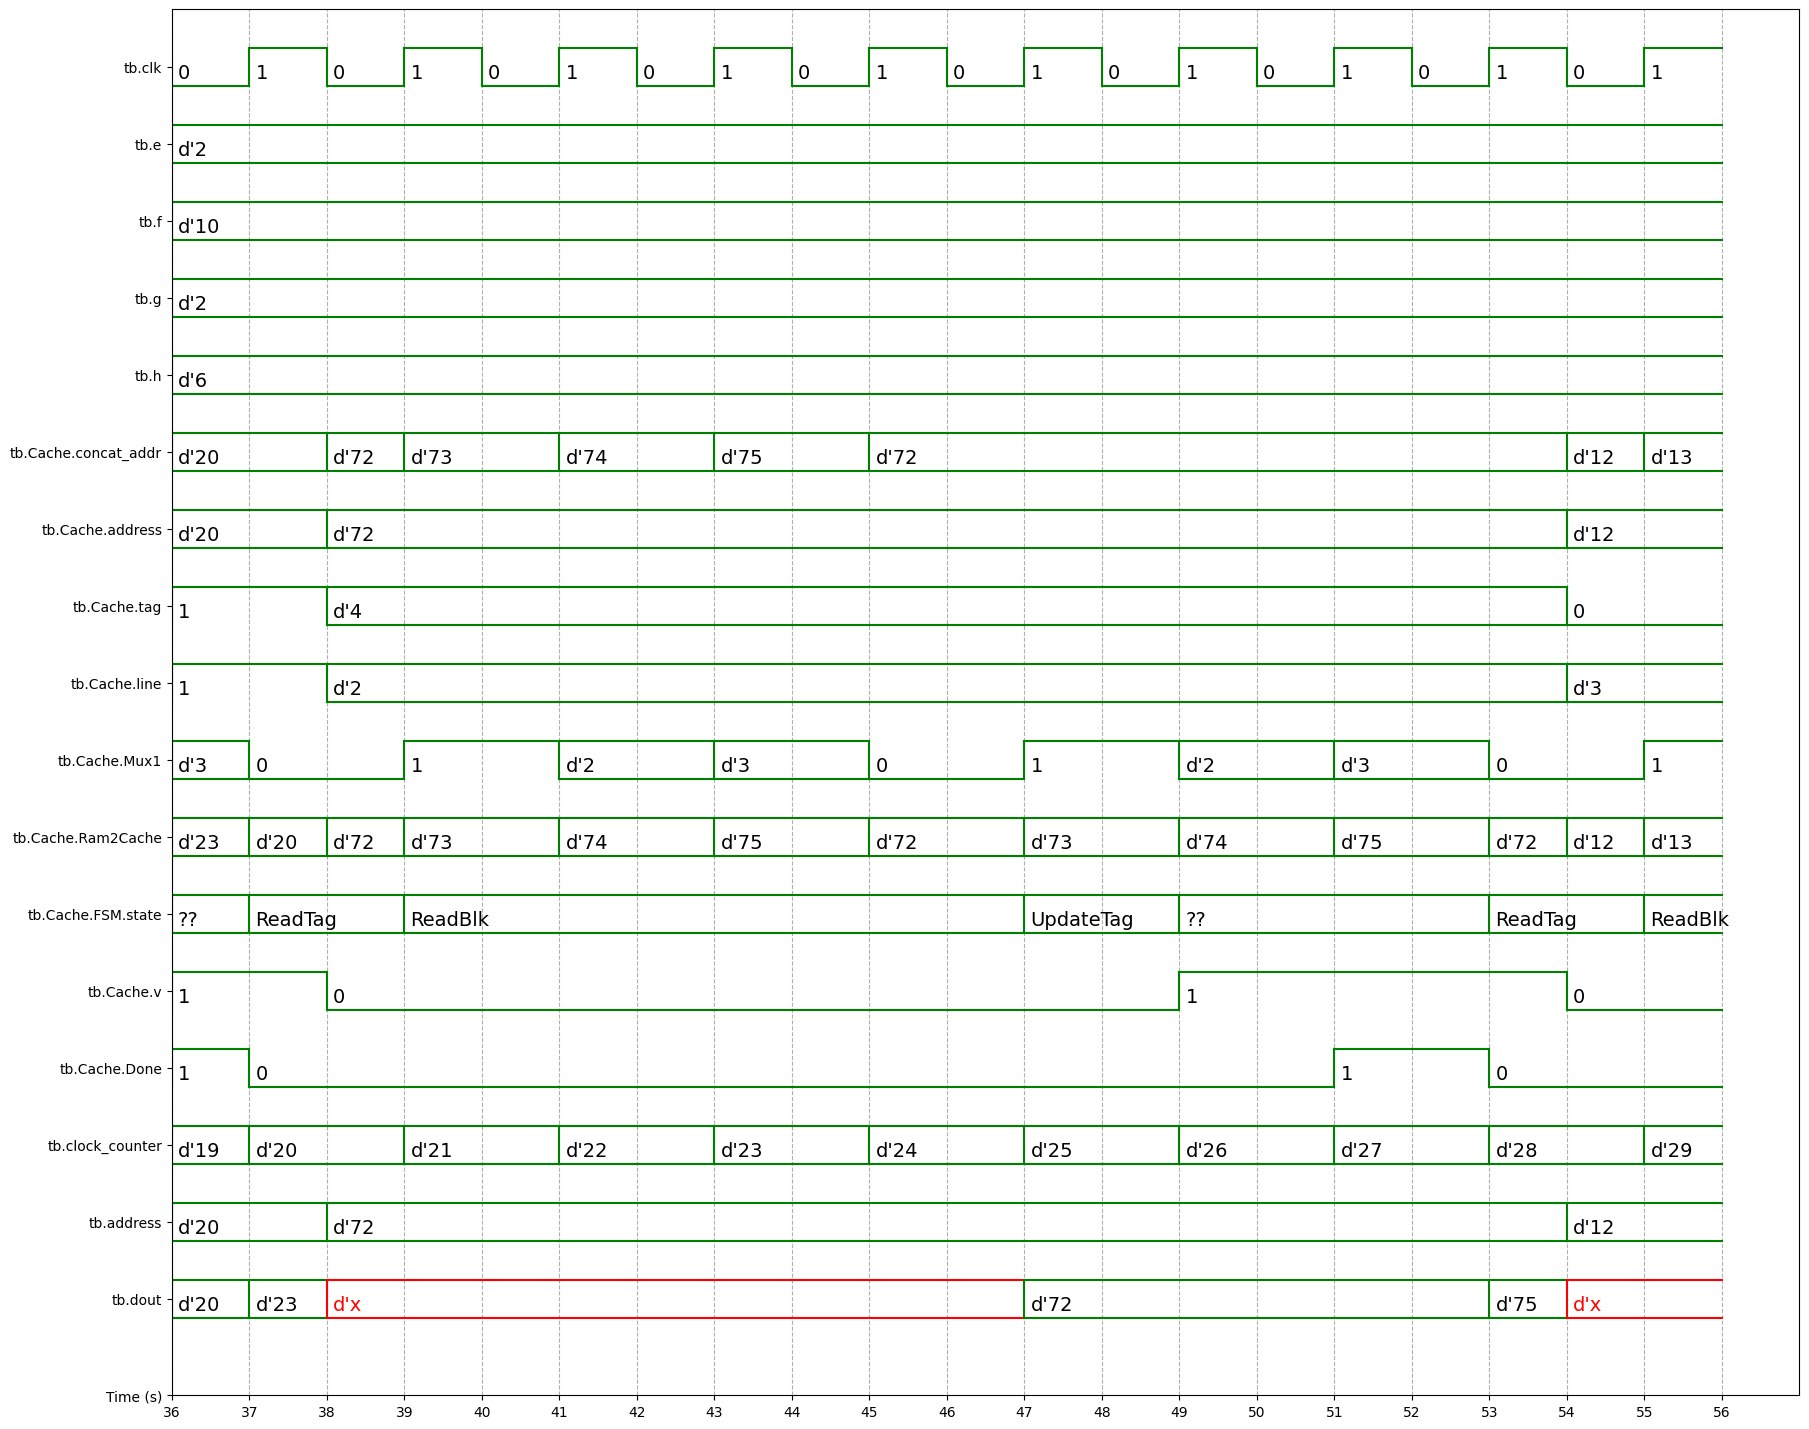

In [65]:
%%waveform test.vcd

op_dict = [{'0':'ReadTag','1':'ReadData','10':'ReadBlk', '11':'UpdateTag', '100':'Reset'}]


sign_list = ['tb.clk', 'tb.e', 'tb.f','tb.g', 'tb.h','tb.Cache.concat_addr', 'tb.Cache.address', 'tb.Cache.tag','tb.Cache.line', 'tb.Cache.Mux1','tb.Cache.Ram2Cache', 'tb.Cache.FSM.state,r[0]','tb.Cache.v', 'tb.Cache.Done', 'tb.clock_counter', 'tb.address', 'tb.dout']
time_begin = 36
time_end = 56
base = 'dec' # bin, dec, dec2, hex, octal

In [ ]:
def printAux(arq1,arq2,arq3):
  arq_valid = open(arq1,'r')
  arq_tag = open(arq2,'r')
  arq_caches = open(arq3,'r')

  def erase(list):
    for auto in list:
      if auto[0] == '/': list.remove(auto)

  valids = arq_valid.readlines()
  tags = arq_tag.readlines()
  caches = arq_caches.readlines()

  erase(valids)
  erase(tags)
  erase(caches)

  stop = int((len(caches))/len(tags))
  valid = iter(valids)
  cache = iter(caches)

  j = int(0)
  i = int(0)

  print("Line| V | Tag | Data")
  print("---|---|---|---|")

  for tag in tags:
    print(i,end = " | ")
    aux = valid.__next__().rstrip('\n')
    print(aux,end=" | ")
    print(tag.rstrip('\n'),end=" | ")
    # for cache in caches:
    try:
      while True:
        if  j == stop * (i+1):
          print()
          break
        print(cache.__next__().rstrip('\n'),end = " ")
        j+=1
    except StopIteration:
      aux = 1  #ignore
    i+=1
    arq_valid.close()
    arq_tag.close()
    arq_caches.close()
def printData():
    printAux("valid.data","tag.data","cache.data")

printData()

Line| V | Tag | Data
---|---|---|---|
0 | 1 | 00 | 00 01 02 03
1 | 0 | 04 | xx xx xx xx
2 | 1 | 01 | 48 49 4a 4b
3 | 1 | 00 | 0c 0d 0e 0f
4 | 0 | xx | xx xx xx xx
5 | 1 | 00 | 14 15 16 17
6 | 0 | xx | xx xx xx xx
7 | 1 | 00 | 1c 1d 1e 1f
8 | 0 | xx | xx xx xx xx
9 | 0 | xx | xx xx xx xx
10 | 0 | xx | xx xx xx xx
11 | 0 | xx | xx xx xx xx
12 | 0 | xx | xx xx xx xx
13 | 0 | xx | xx xx xx xx
14 | 0 | xx | xx xx xx xx
15 | 0 | xx | xx xx xx xx

The previous table is code in Markdown format, copy and paste it here

[Excalidraw](https://excalidraw.com/#json=DDALUe6srMoFgedZ_flB-,ie_pgkZ2v-8zhfrhHO2CFQ)

Line| V | Tag | Data
---|---|---|---|
0 | 1 | 00 | 00 01 02 03
1 | 1 | 01 | 14 15 16 17
2 | 1 | 04 | 48 49 4a 4b
3 | 1 | 01 | 1c 1d 1e 1f

## Interface Gradio

**Gradio** is an interface module that allows you create an url so you may communicate to Colab.

This Gradio module receive cache parameters and generate a verilog file with cache and sequence of access, then it compiles the file and run it. Once it's done, returns the interface showing the table data.

### Installing Gradio

In [ ]:
!pip install gradio &> /dev/null

### This python function is responsable for compiling and executing verilog code


In [ ]:

import os
import subprocess
import tempfile
import uuid

from IPython.core.magic import Magics, cell_magic, magics_class
from IPython.core.magic_arguments import argument, magic_arguments, parse_argstring
from common import helper

compiler = 'iverilog'
ext = '.v'

def Install():
        print("Installing iverilog. Please wait... ", end="")
        args = ["sh", "/content/cad4u/verilog/update_install.sh"]

        output = subprocess.check_output(args, stderr=subprocess.STDOUT)
        output = output.decode('utf8')
        #helper.print_out(output)
        print("done!")

def compile(file_path, flags):

        args = [compiler, file_path + ext, "-o", file_path + ".out"]

        # adding flags: -O3, -unroll-loops, ...
        for flag in flags:
            if flag == "<":
                break
            args.append(flag)

        subprocess.check_output(args, stderr=subprocess.STDOUT)


def run(file_path, flags):
        file_path = file_path + ".out"
        args = [file_path]
        for flag in flags:
          args.append(flag)

        output = subprocess.check_output(args, stderr=subprocess.STDOUT)
        output = output.decode('utf8')
        helper.print_out(output)

Install()
flags = ""
file_path = "/content/tb"
compile(file_path, flags)
run(file_path,"1")

In [ ]:
import gradio as gr
import time
import math

# def numberInByts(n):
#   if (n == 0 or n == 1): return 1
#   return int((math.log(n) / math.log(2)) + 1)

def result(tagFormat):
  arq_valid = open('valid.data','r')
  arq_tag = open('tag.data','r')
  arq_caches = open('cache.data','r')

  def erase(list):
    for auto in list:
      if auto[0] == '/': list.remove(auto)

  #read files and delete comments
  valids = arq_valid.readlines()
  tags = arq_tag.readlines()
  caches = arq_caches.readlines()

  #closes used files
  arq_valid.close()
  arq_tag.close()
  arq_caches.close()

  erase(valids)
  erase(tags)
  erase(caches)

  #iterator for data list
  valid = iter(valids)
  cache = iter(caches)
  tag = iter(tags)

  #current cache row counter
  k = int(0)
  lineNumber = int(len(caches)/len(tags))

  #list of list (here will be added as table rows)
  result = []

  for i in range(len(tags)):

    aux = []
    #adds the line, valid bit and tag, to the current column(aux)
    aux.append(i)
    aux.append(valid.__next__().rstrip('\n'))
    aux.append(tag.__next__().rstrip('\n'))

    #add all block values
    s = ""
    for j in range(lineNumber):
      s = s + caches[j + k].rstrip('\n') + " "

    aux.append(s)
    k = lineNumber *(i+1)

    if (aux[2] != "xx" and aux[2] != "x"):
      tagInHex = hex(int(aux[2], 16))
      tagInBits = bin(int(tagInHex, 16))

      aux[2] = tagInHex

      if (tagFormat == "binary"):
        aux[2] = tagInBits

      if (tagFormat == "decimal"):
        aux[2] = int(tagInBits,2)

    result.append(aux)

  return result

def newcode(address,cacheSize,ramSize,blockSize,tagFormat):
  address = address[:-1] if address[-1] == "," else address
  newAddress = str(address).strip().split(',')

  #write the addresses consulted
  my_file=open("/content/input.v","w")
  for i in range(len(newAddress)):
    my_file.write("address = ")
    my_file.write(newAddress[i])
    my_file.write(';\n#50\n')
  my_file.close()

  #write the parameter data
  parameter=open("/content/parameter.v","w")
  parameter.write("parameter cacheSize = ")
  parameter.write(str(int(cacheSize)))
  parameter.write(";\nparameter ramSize = ")
  parameter.write(str(int(ramSize)))
  parameter.write(";\nparameter blockSize = ")
  parameter.write(str(int(blockSize)))
  parameter.write(";\n")
  parameter.close()

  time.sleep(0.25)
  compile(file_path, flags)
  run(file_path,"1")

  addressBitsSize = math.ceil(math.log(int(ramSize), 2))
  blockBitsSize = math.ceil(math.log(int(blockSize), 2))
  linesTotal = math.ceil(math.log(int(cacheSize) / int(blockSize), 2))
  tagBitsSize = addressBitsSize - int(blockBitsSize) - linesTotal

  INSTRUCTION_BREAKDOWN = f"Addres= {addressBitsSize} bits, Tag = {tagBitsSize} bits, Lines = {int(linesTotal)} bits, blk = {blockBitsSize} bits"

  return [INSTRUCTION_BREAKDOWN, result(tagFormat)]


firstFieldLabel = "Insert the address numbers to consult"
secondFieldLabel = "Cache size"
thirdFieldLabel = "Ram size"
fourthFieldLabel = "Block size"
defaultHeaders = ["Line","V","Tag", "Data"]
tagDisplayFormat = "TAG DISPLAY FORMAT"

iface = gr.Interface(
    fn=newcode,
    inputs=[
        gr.inputs.Textbox(3,label=firstFieldLabel),
        gr.inputs.Dropdown(choices=[8,16,32,64,128],label=secondFieldLabel),
        gr.inputs.Dropdown(choices=[1024,2048,4096,8192],label=thirdFieldLabel),
        gr.inputs.Dropdown(choices=[4,8,16,32],label=fourthFieldLabel),
        gr.inputs.Radio(choices=["decimal", "binary", "hex"], default="decimal", label=tagDisplayFormat)],
outputs=[
         gr.outputs.Textbox(label="Instruction Breakdown"),
         gr.outputs.Dataframe(label="Cache Table", headers=defaultHeaders, max_rows=128, type="array")])

iface.launch(share=True)